In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import matplotlib.pyplot as plt

import numpy as np

import denoise
import noise_estimator
import util_plot
#import caiman as cm

In [2]:
from skimage import io
mov = io.imread('example_movies/demoMovie.tif').transpose([1,2,0])
print(mov.shape)

(60, 80, 2000)


### Spatial denoiser (optional)

To denoise the video spatially, we can employ an anisotropic Wiener Filter. Each pixel is denoised by strengthening its covariance with neighboring pixels, but accounting for the different noise levels estimated for each pixel in the group via their PSD.

In [ ]:
mov_wf = denoise.spatial(mov, gHalf=[2,2])

In [ ]:
util_plot.comparison_plot([mov, mov_wf],
                          option='corr',
                          titles_=['Movie', 'WF Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

### Temporal denoiser

The video can be denoised temporally through block PCA. We begin by subtracting the mean and normalizing each pixel by the noise variance. The video is partitioned in tiles (~ soma size). PCA is applied to each tile to extract spatial and temporal components. The temporal components with Gaussian like autocorrelation are rejected. When the SNR is low, some block artifacts can be present. To compensate for this, we run this approach 3x more using 1/2 off grids (row-,column-, and row&column- wise) of the original block partitions. The then average these results to obtain a single denoised movie.

In [3]:
mov_mean  = mov.mean(2,keepdims=True)
mov = mov - mov_mean
noise_level = denoise.noise_level(mov,
                                  range_ff=[0.25,0.5])
mov_nn = mov/noise_level[:,:,np.newaxis]

Partition the movie in tiles smaller than the avg soma size.

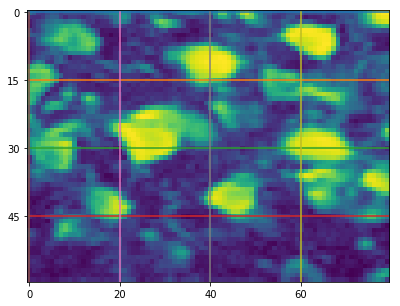

In [4]:
nblocks=[4,4]
Cn1,_ = util_plot.correlation_pnr(mov_nn)
util_plot.tiling_grid_plot(Cn1,
                           nblocks=nblocks,
                           plot_option='same')

Set dx to either {1,4} (number of denoisers) depending on SNR.<br/>
We begin by running the denoiser as vanilla PCA (greedy= False).<br/>
See function comments for detailed descriptions.<br/>

In [5]:
import greedyPCA_SV as gpca


# Extract background (top components)

In [6]:
n_components = 6
dims = mov_nn.shape
M = mov_nn.reshape((np.prod(dims[:2]),dims[2]))
R =gpca.compute_svd(M,
                    method='randomized',
                    n_components=n_components,
                    reconstruct=True).reshape(dims)
D = mov_nn - R

running denoiser on residual after extracting background from original movie

# Running vanilla PCA denoiser without SNR threshold

In [7]:
nblocks =[2,2]
mov_d_vpca_t0,ranks_vpca_t0 = denoise.temporal(D,
                               nblocks=nblocks,
                               min_rank=1,
                               greedy= False,
                               snr_threshold=0,
                               dx=1)

parallel version not for Darwin
Tile 0
0
	Y rank:31	run_time: 3.672617
Tile 1
0
	Y rank:32	run_time: 3.213274
Tile 2
0
	Y rank:25	run_time: 2.960638
Tile 3
0
	Y rank:27	run_time: 2.933258
Blocks(=4) run time: 12.849279


Local correlation:  range [1.7e-02 9.5e-01]
Local correlation:  range [1.3e-01 9.9e-01]
Local correlation:  range [2.5e-03 1.9e-01]


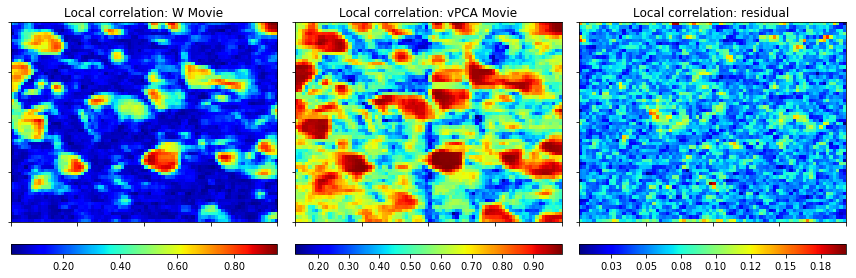

In [8]:
util_plot.comparison_plot([D, mov_d_vpca_t0],
                          option='corr',
                          titles_=['W Movie', 'vPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

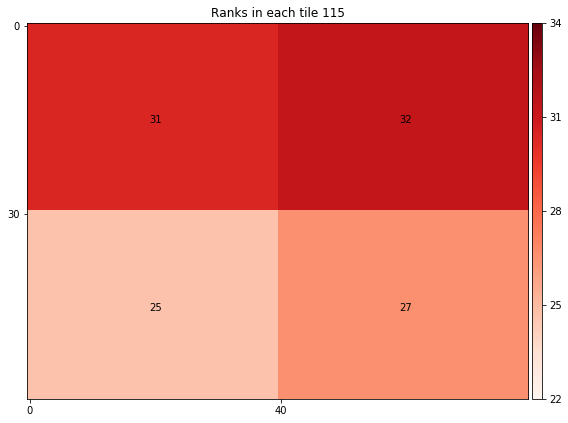

In [9]:
dims =D.shape
_ = util_plot.cn_ranks_plot(ranks_vpca_t0,
                               dims,
                               nblocks=nblocks,
                               figsize=8,
                               fontsize=10)

# Running vanilla PCA denoiser with SNR threshold

In [11]:
nblocks =[2,2]
mov_d_vpca,ranks_vpca = denoise.temporal(D,
                               nblocks=nblocks,
                               min_rank=1,
                               greedy= False,
                                snr_threshold=1.9,
                               dx=1)

parallel version not for Darwin
Tile 0
19
	Y rank:12	run_time: 3.511454
Tile 1
18
	Y rank:14	run_time: 3.483484
Tile 2
18
	Y rank:7	run_time: 3.508644
Tile 3
15
	Y rank:12	run_time: 3.834867
Blocks(=4) run time: 14.395071


Local correlation:  range [1.7e-02 9.5e-01]
Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [1.1e-02 5.0e-01]


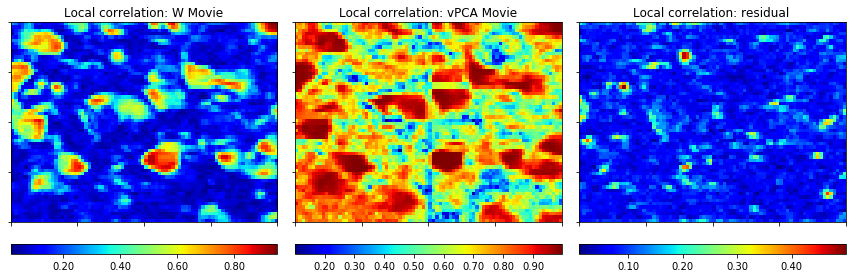

In [12]:
util_plot.comparison_plot([D, mov_d_vpca],
                          option='corr',
                          titles_=['W Movie', 'vPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

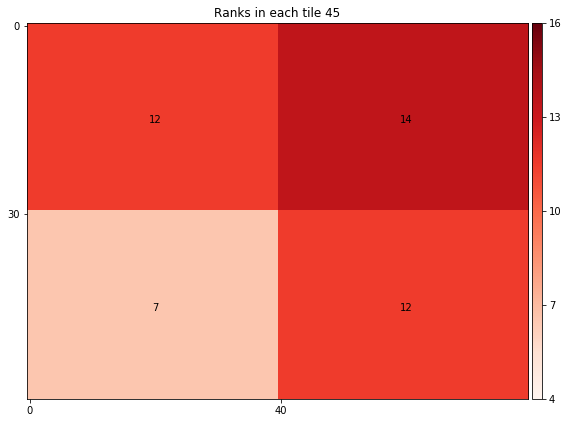

In [13]:
dims =D.shape
_ = util_plot.cn_ranks_plot(ranks_vpca,
                               dims,
                               nblocks=nblocks,
                               figsize=8,
                               fontsize=10)

### Compare vanilla PCA with and without SNR threshold

Local correlation:  range [1.3e-01 9.9e-01]
Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [4.3e-02 8.7e-01]


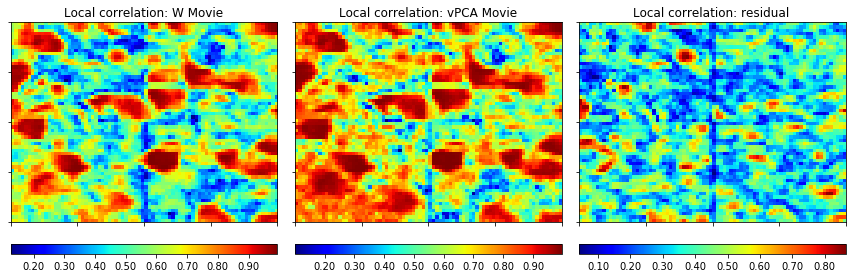

In [14]:
util_plot.comparison_plot([mov_d_vpca_t0, mov_d_vpca],
                          option='corr',
                          titles_=['W Movie', 'vPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

# Running greedy PCA denoiser without SNR threshold

In [15]:
nblocks =[2,2]
mov_d_gpca_t0,ranks_gpca_t0 = denoise.temporal(D,
                               nblocks=nblocks,
                               min_rank=1,
                               greedy= True,
                                snr_threshold=0,
                               dx=1)

parallel version not for Darwin
Tile 0
0
	Y rank:31	run_time: 9.031624
Tile 1
0
	Y rank:32	run_time: 15.299509
Tile 2
0
	Y rank:25	run_time: 15.149622
Tile 3
0
	Y rank:27	run_time: 15.019208
Blocks(=4) run time: 54.550301


Local correlation:  range [1.7e-02 9.5e-01]
Local correlation:  range [7.0e-02 9.9e-01]
Local correlation:  range [-1.6e-03 2.1e-01]


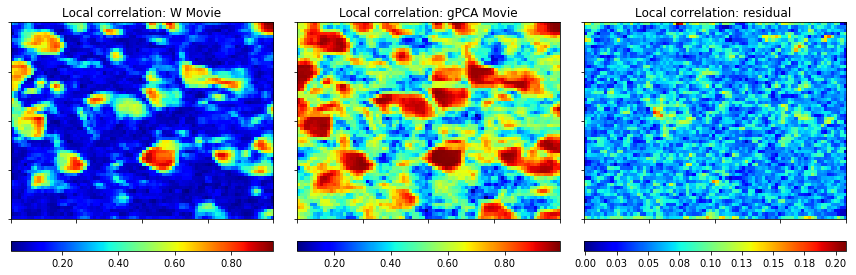

In [16]:
util_plot.comparison_plot([D, mov_d_gpca_t0],
                          option='corr',
                          titles_=['W Movie', 'gPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

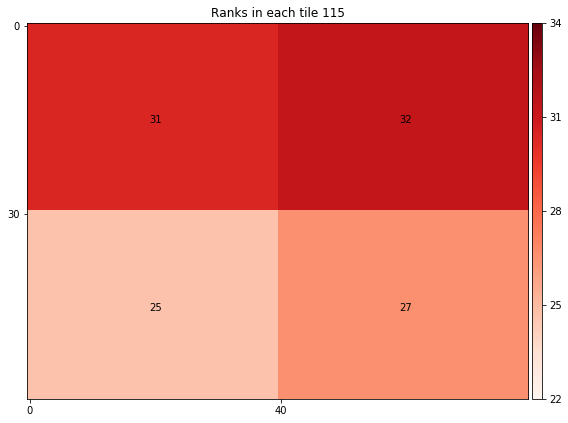

In [17]:
dims =D.shape
_ = util_plot.cn_ranks_plot(ranks_gpca_t0,
                               dims,
                               nblocks=nblocks,
                               figsize=8,
                               fontsize=10)

## Running greedy denoiser with SNR threshold

In [18]:
nblocks =[2,2]
mov_d_gpca,ranks_gpca = denoise.temporal(D,
                               nblocks=nblocks,
                               min_rank=1,
                               greedy= True,
                                snr_threshold=1.9,
                               dx=1)

parallel version not for Darwin
Tile 0
19
	Y rank:12	run_time: 5.283580
Tile 1
18
	Y rank:14	run_time: 4.818977
Tile 2
18
	Y rank:7	run_time: 4.539048
Tile 3
15
	Y rank:12	run_time: 4.896813
Blocks(=4) run time: 19.607175


Local correlation:  range [1.7e-02 9.5e-01]
Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [7.3e-03 4.7e-01]


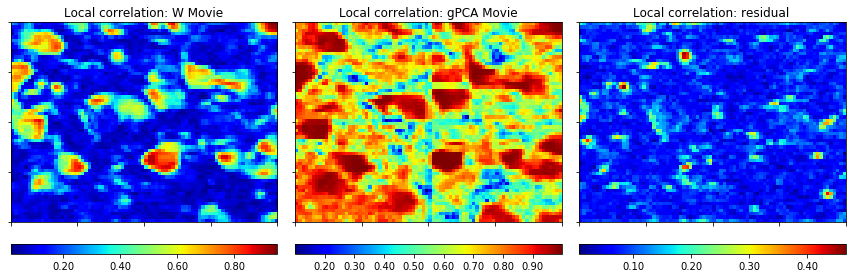

In [19]:
util_plot.comparison_plot([D, mov_d_gpca],
                          option='corr',
                          titles_=['W Movie', 'gPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

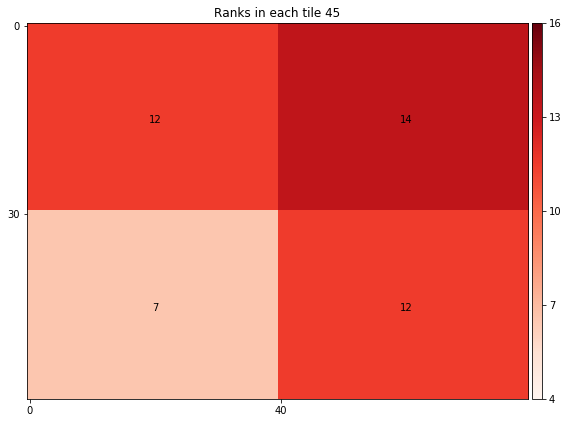

In [20]:
dims =D.shape
_ = util_plot.cn_ranks_plot(ranks_gpca,
                               dims,
                               nblocks=nblocks,
                               figsize=8,
                               fontsize=10)

### Compare vanilla and greedy outputs without SNR threshold

Local correlation:  range [1.3e-01 9.9e-01]
Local correlation:  range [7.0e-02 9.9e-01]
Local correlation:  range [-5.8e-03 4.8e-01]


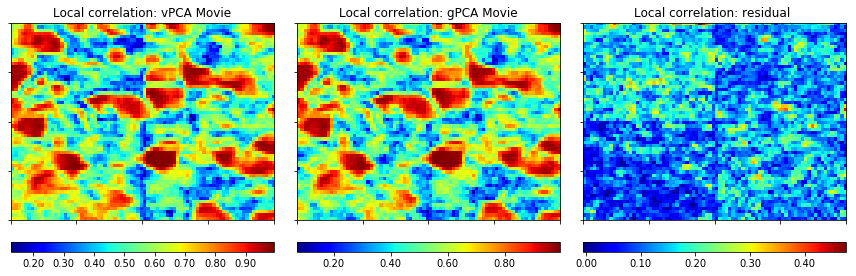

In [21]:
util_plot.comparison_plot([mov_d_vpca_t0,mov_d_gpca_t0],
                          option='corr',
                          titles_=['vPCA Movie', 'gPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

### Compare vanilla and greedy outputs with SNR threshold

Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [-4.6e-02 6.8e-01]


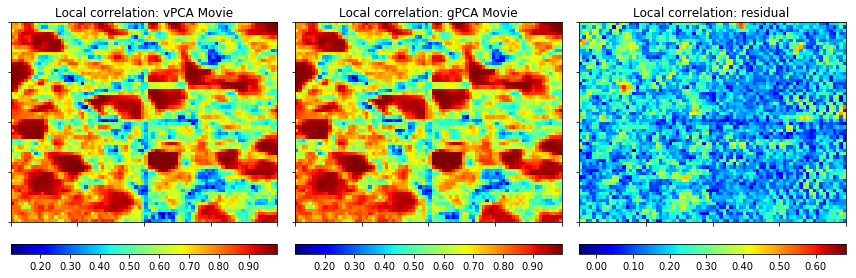

In [22]:
util_plot.comparison_plot([mov_d_vpca, mov_d_gpca],
                          option='corr',
                          titles_=['vPCA Movie', 'gPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

## Running rank n extraction with randomized SVD

In [23]:
n_components = 45
dims = D.shape
M1 = D.reshape((np.prod(dims[:2]),dims[2]))
R1 =gpca.compute_svd(M1,
                    method='randomized',
                     n_components=n_components,
                     reconstruct=True).reshape(dims)

Local correlation:  range [1.7e-02 9.5e-01]
Local correlation:  range [3.2e-02 9.9e-01]
Local correlation:  range [1.2e-02 3.3e-01]


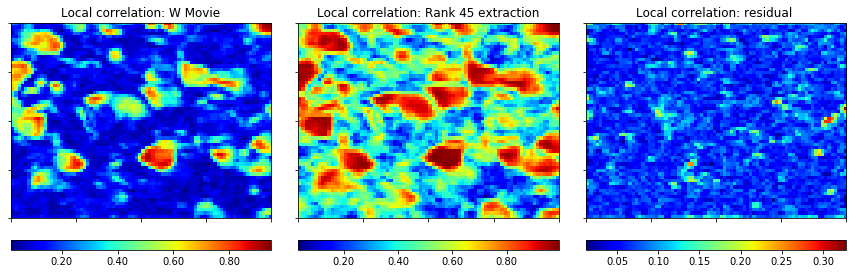

In [24]:
util_plot.comparison_plot([D, R1],
                          option='corr',
                          titles_=['W Movie', 'Rank '+str(n_components)+' extraction'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

### Compare randomized extraction with vanilla PCA

Local correlation:  range [1.3e-01 9.9e-01]
Local correlation:  range [3.2e-02 9.9e-01]
Local correlation:  range [8.7e-03 6.9e-01]


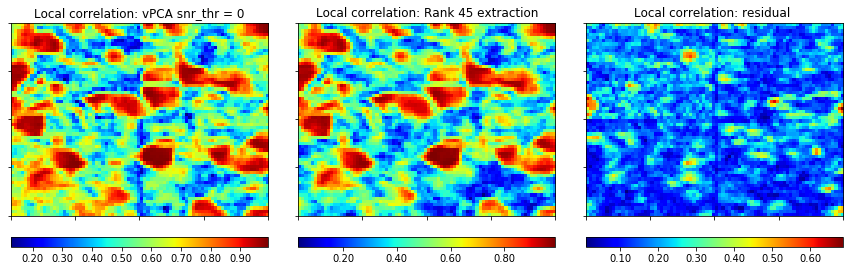

In [25]:
util_plot.comparison_plot([mov_d_vpca_t0, R1],
                          option='corr',
                          titles_=['vPCA snr_thr = 0', 'Rank '+str(n_components)+' extraction'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [3.2e-02 9.9e-01]
Local correlation:  range [2.0e-02 7.6e-01]


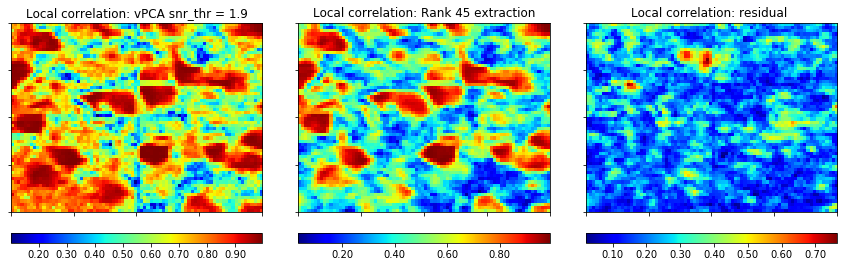

In [26]:
util_plot.comparison_plot([mov_d_vpca, R1],
                          option='corr',
                          titles_=['vPCA snr_thr = 1.9', 'Rank '+str(n_components)+' extraction'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

### Compare randomized extraction with greedy PCA

Local correlation:  range [7.0e-02 9.9e-01]
Local correlation:  range [3.2e-02 9.9e-01]
Local correlation:  range [1.9e-02 7.9e-01]


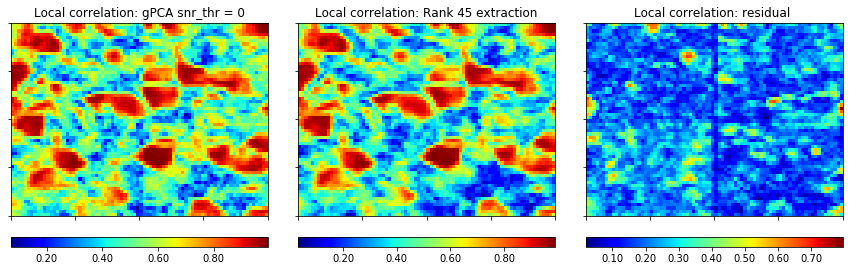

In [27]:
util_plot.comparison_plot([mov_d_gpca_t0, R1],
                          option='corr',
                          titles_=['gPCA snr_thr = 0', 'Rank '+str(n_components)+' extraction'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )

Local correlation:  range [1.0e-01 1.0e+00]
Local correlation:  range [3.2e-02 9.9e-01]
Local correlation:  range [3.8e-03 7.5e-01]


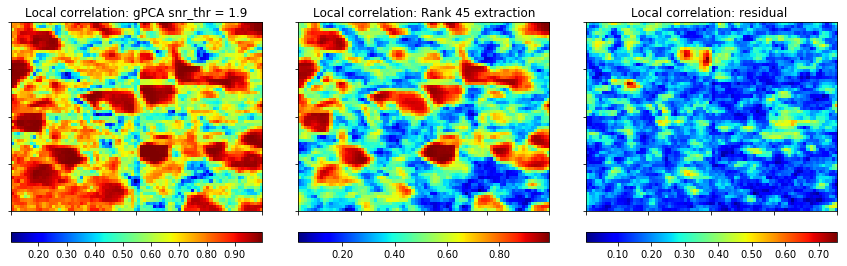

In [29]:
util_plot.comparison_plot([mov_d_gpca, R1],
                          option='corr',
                          titles_=['gPCA snr_thr = 1.9', 'Rank '+str(n_components)+' extraction'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal'
                         )